# 1. Make classification data and getting it ready

## 1.1 Data generation and understanding data

In [1]:
import sklearn
from sklearn.datasets import make_moons

# Make 1000 samples
n_samples = 1000

X,y = make_moons(n_samples,
                 noise=0.03,
                 random_state=42)

X.shape,y.shape

((1000, 2), (1000,))

In [2]:
# printing first 5 samples
print(f"First 5 samples of x: {X[:5]}")
print(f"First 5 samples of y:{y[:5]}")

First 5 samples of x: [[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]
First 5 samples of y:[1 1 1 1 0]


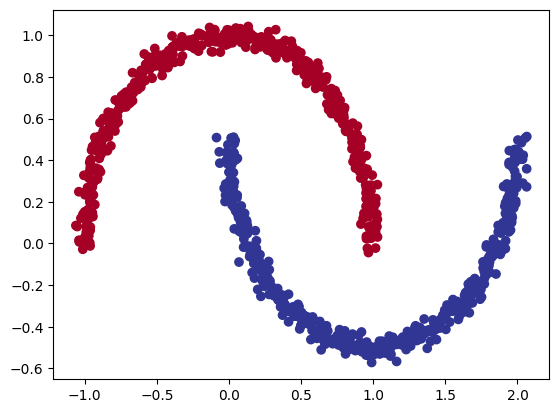

In [3]:
# Visualising the data
import matplotlib.pyplot as plt

plt.scatter(X[:,0],X[:,1],c=y,cmap='RdYlBu')

In [4]:
# Understanding the data using pandas
# Seeing which class has how many data points

# Make dataframes of circles data
import pandas as pd

moons = pd.DataFrame({"X1":X[:,0],
                     "X2":X[:,1],
                     "label":y})

moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


In [5]:
moons.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

This shows that there are 500 data points that belong to class 0 and 500 data points belong to class 1

In [6]:
# See the first sample to understand the shape perfectly
x_sample, y_sample = X[0],y[0]
x_sample, y_sample

(array([-0.00933187,  0.39098105]), 1)

In [7]:
X.shape,y.shape

((1000, 2), (1000,))

## 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn data into tensors

import torch
print(torch.__version__)

2.3.0+cu121


In [9]:
type(X)

numpy.ndarray

In [10]:
# Turning data from numpy array into a tensor
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X.dtype, y.dtype, X.shape, y.shape

(torch.float32, torch.float32, torch.Size([1000, 2]), torch.Size([1000]))

In [11]:
X[:5],y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
# Split data into train and test datasets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

# 2. Building a model

In [13]:
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [14]:
class MoonModelV0(nn.Module):
  def __init__(self,input_size,hidden_units,output_size):
    super().__init__()

    # Creating a combination of linear and non-linear layers
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_size)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [15]:
X.ndim

2

In [16]:
model_0 = MoonModelV0(input_size=X.ndim,
                      hidden_units = 10,
                      output_size=1).to(device) # Since a binary classification problem
model_0

MoonModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

# 3. Setting up a loss function and optimizer compatible to binary classification


In [17]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # Takes logits as input, not pred label

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

loss_fn,optimizer

(BCEWithLogitsLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

# 4. Creating training and testing loop to fit the model

In [18]:
from sklearn.metrics import accuracy_score

# Training loop and testing loop

torch.manual_seed(42)

# Putting the data on the target device
X_train, X_test, y_train, y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

# Epochs
epochs = 1000

for epoch in range(epochs):
  model_0.train()

  # Do the forward pass
  y_pred_logits = model_0(X_train).squeeze() # logits
  y_pred_labels = torch.round(torch.sigmoid(y_pred_logits))

  # Calculate the loss/accuracy
  loss = loss_fn(y_pred_logits,y_train)
  acc = accuracy_score(y_train.cpu().detach().numpy(),y_pred_labels.cpu().detach().numpy())

  # Optimizer zero grad
  optimizer.zero_grad()

  # loss.backward()
  loss.backward()

  # optmizer step step step
  optimizer.step()

  ### Testing

  model_0.eval()
  with torch.inference_mode():
    # Do the forward pass
    y_test_preds_logits = model_0(X_test).squeeze()
    y_test_preds_labels = torch.round(torch.sigmoid(y_test_preds_logits))

    # Calculate the loss / Acc
    test_loss =  loss_fn(y_test_preds_logits,y_test)
    test_acc = accuracy_score(y_test.cpu().detach().numpy(),y_test_preds_labels.cpu().detach().numpy())

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch:{epoch} | Train loss: {loss:.3f} | Train Acc : {acc:.2f} | Test loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}")



Epoch:0 | Train loss: 0.717 | Train Acc : 0.50 | Test loss: 0.712 | Test Acc: 0.50
Epoch:100 | Train loss: 0.395 | Train Acc : 0.85 | Test loss: 0.402 | Test Acc: 0.85
Epoch:200 | Train loss: 0.249 | Train Acc : 0.88 | Test loss: 0.254 | Test Acc: 0.89
Epoch:300 | Train loss: 0.233 | Train Acc : 0.89 | Test loss: 0.234 | Test Acc: 0.90
Epoch:400 | Train loss: 0.223 | Train Acc : 0.90 | Test loss: 0.224 | Test Acc: 0.90
Epoch:500 | Train loss: 0.213 | Train Acc : 0.90 | Test loss: 0.217 | Test Acc: 0.90
Epoch:600 | Train loss: 0.206 | Train Acc : 0.90 | Test loss: 0.213 | Test Acc: 0.89
Epoch:700 | Train loss: 0.203 | Train Acc : 0.91 | Test loss: 0.211 | Test Acc: 0.88
Epoch:800 | Train loss: 0.201 | Train Acc : 0.90 | Test loss: 0.211 | Test Acc: 0.88
Epoch:900 | Train loss: 0.200 | Train Acc : 0.90 | Test loss: 0.211 | Test Acc: 0.88


In [19]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

# 5. Evaluating the model

In [20]:
model_0.eval()
with torch.inference_mode():
  # Do the forward pass
  test_pred_logits = model_0(X_test).squeeze()
  test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))

  # Calculate the loss/Accuracy
  test_loss = loss_fn(test_pred_logits,y_test)
  test_acc = accuracy_score(y_test.cpu().detach().numpy(),test_pred_labels.cpu().detach().numpy())

  print(f"test Loss: {test_loss} | Test Acc: {test_acc}")



test Loss: 0.2104616016149521 | Test Acc: 0.875


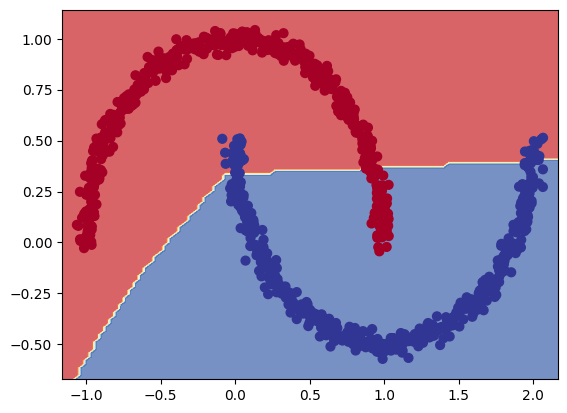

In [21]:
# Plotting decision boundary
plot_decision_boundary(model_0,X,y)

# Spiral dataset - Multiclass classification problem

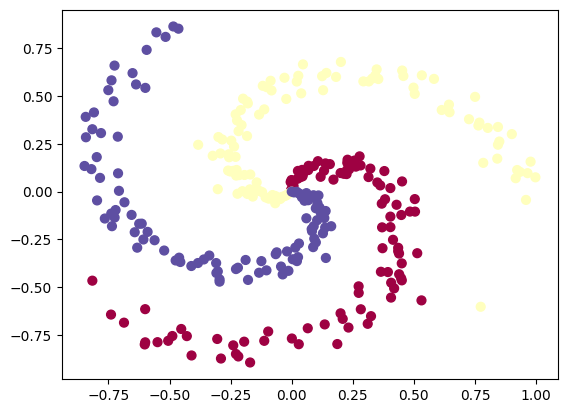

In [22]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [23]:
X.shape, y.shape

((300, 2), (300,))

In [24]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([240, 2]),
 torch.Size([60, 2]),
 torch.Size([240]),
 torch.Size([60]))

In [25]:
y_train[:5]

tensor([2, 0, 0, 1, 1])

In [26]:
torch.unique(y_train) # 3 different classes

tensor([0, 1, 2])

In [27]:
# Setting up the model

# Hyperparameters
NUM_CLASSES = len(torch.unique(y_train)) # 3
NUM_FEATURES = X.ndim
HIDDEN_UNITS = 10

model_1 = MoonModelV0(input_size=NUM_FEATURES,
                      hidden_units=HIDDEN_UNITS,
                      output_size = NUM_CLASSES).to(device) # Number of classes
model_1, next(model_1.parameters()).device

(MoonModelV0(
   (layer_stack): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): ReLU()
     (2): Linear(in_features=10, out_features=10, bias=True)
     (3): ReLU()
     (4): Linear(in_features=10, out_features=3, bias=True)
   )
 ),
 device(type='cpu'))

In [28]:
# Creating a loss function and an optimizer for the multi-class classification problem

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

loss_fn, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

In [29]:
# Getting the prediction probabilities with the untrained model_1

model_1.eval()
with torch.inference_mode():
  y_eval_pred_logits = model_1(X_test.to(device))

print(y_eval_pred_logits[:5])


tensor([[-0.2213, -0.0604,  0.2363],
        [-0.2297, -0.0641,  0.2426],
        [-0.2231, -0.0537,  0.2433],
        [-0.2225, -0.0602,  0.2396],
        [-0.2177, -0.0617,  0.2238]])


In [30]:
# Converting prediction logits into prediction probabilities
y_eval_pred_probs = torch.softmax(y_eval_pred_logits,dim=1) # Across rows

print(y_eval_pred_probs[:5])

tensor([[0.2663, 0.3128, 0.4209],
        [0.2643, 0.3119, 0.4238],
        [0.2646, 0.3135, 0.4219],
        [0.2657, 0.3125, 0.4218],
        [0.2685, 0.3139, 0.4176]])


In [31]:
# Converting prediction probabilities into prediction labels
y_eval_labels = torch.argmax(y_eval_pred_probs,dim=1)
print(y_eval_labels[:5])

tensor([2, 2, 2, 2, 2])


In [32]:
y_eval_labels.shape, y_test.shape

(torch.Size([60]), torch.Size([60]))

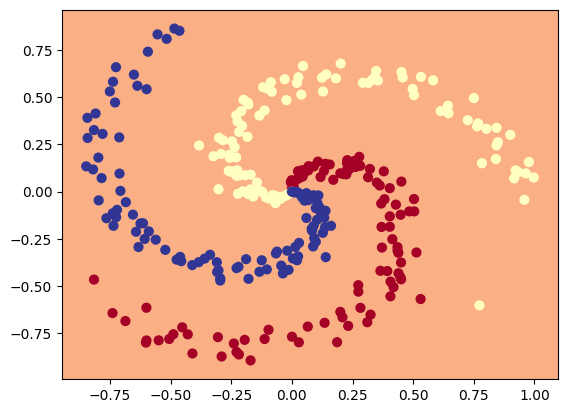

In [33]:
# Plotting the decision boundary
plot_decision_boundary(model_1, X,y)

In [34]:
### Training the model
torch.manual_seed(42)

# Sending data to the right device
X_train, X_test, y_train, y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

# Making sure the model is on the right device
model_1.to(device)

# Epochs
epochs = 2000

for epoch in range(epochs):
  # Do the forward pass
  y_pred_logits = model_1(X_train).squeeze()
  y_pred_labels = torch.softmax(y_pred_logits,dim=1).argmax(dim=1)

  # Calculate the loss/acc score
  loss = loss_fn(y_pred_logits,y_train)
  acc = accuracy_score(y_train.cpu().detach().numpy(), y_pred_labels.cpu().detach().numpy())

  # optimizer zero_grad
  optimizer.zero_grad()

  # loss.backward
  loss.backward()

  # optimizer step step step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # Do the forward pass
    test_pred_logits = model_1(X_test).squeeze()
    test_pred_labels = torch.softmax(test_pred_logits,dim=1).argmax(dim=1)

    # Calculate the loss/ acc_score
    test_loss = loss_fn(test_pred_logits,y_test)
    test_acc= accuracy_score(y_test.cpu().detach().numpy(),test_pred_labels.cpu().detach().numpy())



    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Train acc: {acc:.2f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.2f}")



Epoch: 0 | Train loss: 1.117 | Train acc: 0.33 | Test loss: 1.110 | Test acc: 0.37
Epoch: 100 | Train loss: 1.080 | Train acc: 0.46 | Test loss: 1.087 | Test acc: 0.42
Epoch: 200 | Train loss: 1.008 | Train acc: 0.50 | Test loss: 1.021 | Test acc: 0.45
Epoch: 300 | Train loss: 0.908 | Train acc: 0.53 | Test loss: 0.938 | Test acc: 0.48
Epoch: 400 | Train loss: 0.845 | Train acc: 0.53 | Test loss: 0.892 | Test acc: 0.42
Epoch: 500 | Train loss: 0.785 | Train acc: 0.56 | Test loss: 0.855 | Test acc: 0.47
Epoch: 600 | Train loss: 0.730 | Train acc: 0.58 | Test loss: 0.824 | Test acc: 0.48
Epoch: 700 | Train loss: 0.675 | Train acc: 0.65 | Test loss: 0.787 | Test acc: 0.58
Epoch: 800 | Train loss: 0.632 | Train acc: 0.67 | Test loss: 0.749 | Test acc: 0.62
Epoch: 900 | Train loss: 0.598 | Train acc: 0.70 | Test loss: 0.717 | Test acc: 0.62
Epoch: 1000 | Train loss: 0.556 | Train acc: 0.74 | Test loss: 0.682 | Test acc: 0.63
Epoch: 1100 | Train loss: 0.507 | Train acc: 0.75 | Test loss: 0.6

In [35]:
# Evaluating the model
model_1.eval()
with torch.inference_mode():
  y_test_pred_logits = model_1(X_test)
  y_test_pred_labels = torch.softmax(y_test_pred_logits,dim=1).argmax(dim=1)

  eval_test_loss = loss_fn(y_test_pred_logits,y_test)
  eval_test_acc = accuracy_score(y_test.cpu().detach().numpy(), y_test_pred_labels.cpu().detach().numpy())

  print(f"Test loss: {eval_test_loss:.3f} | Test acc: {eval_test_acc:.2f}")

Test loss: 0.501 | Test acc: 0.85


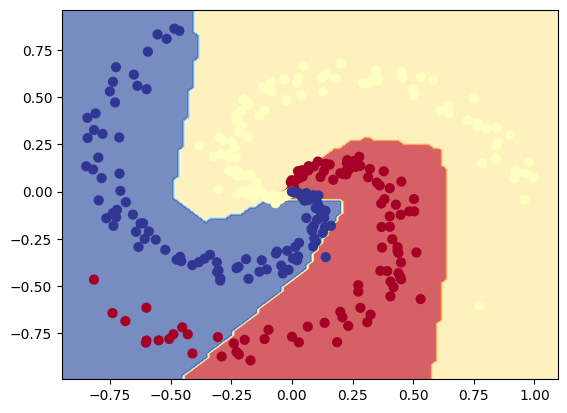

In [36]:
# Plotting the decision boundary
plot_decision_boundary(model_1, X,y)